# Démonstration de l'écosystème géospatial de Python

Import des bibliothèques

In [36]:
import geopandas as gpd
import rasterio as rio

In [5]:
cours_deau = gpd.read_file('../data/COURS_D_EAU.shp')
cours_deau.head()

,ID,CODE_HYDRO,TOPONYME,STATUT_TOP,IMPORTANCE,DATE_CREAT,DATE_MAJ,DATE_APP,DATE_CONF,SOURCE,ID_SOURCE,STATUT,MAREE,PERMANENT,COMMENT,geometry
0,COURDEAU0000002215479238,06C0000002215479238,Canal de Pulivès,Validé,5,2020-10-21 09:35:44,2020-11-12 10:46:00,None,None,None,None,Validé,None,None,None,"LINESTRING (847280.500 6505594.500, 847273.400..."
1,COURDEAU0000002000792297,06C0000002000792297,Torrent du Clot des Cavales,Validé,5,2017-01-24 16:06:18,2022-06-03 22:58:45,None,None,None,None,Validé,None,None,None,"LINESTRING (963060.600 6437049.700, 963068.600..."
2,COURDEAU0000002215478774,06C0000002215478774,le Bouveyron,Validé,5,2020-10-21 09:35:44,2020-11-12 10:46:00,None,None,None,None,Validé,None,None,None,"LINESTRING (895311.900 6452665.700, 895271.300..."
3,COURDEAU0000002000803076,06C0000002000803076,Ruisseau de la Combe de Mouze,Validé,5,2017-01-24 16:06:18,2020-09-28 10:34:31,None,None,None,None,Validé,None,None,None,"LINESTRING (878398.000 6459581.500, 878400.900..."
4,COURDEAU0000002215480545,06C0000002215480545,le Pachoux,Validé,5,2020-10-21 09:35:44,2020-11-12 10:46:00,None,None,None,None,Validé,None,None,None,"LINESTRING (945273.400 6484691.600, 945299.600..."


<Axes: >

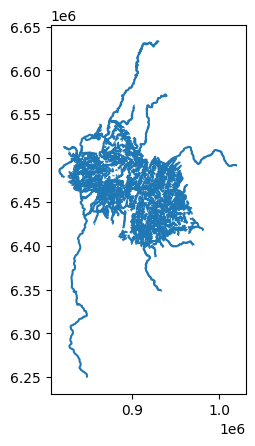

In [37]:
cours_deau.plot()

<Axes: >

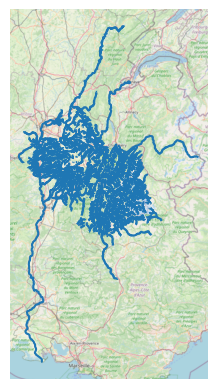

In [38]:
import contextily as cx

ax = cours_deau.to_crs('EPSG:3857').plot()
cx.add_basemap(ax, source='https://tile.openstreetmap.org/{z}/{x}/{y}.png')
ax.set_axis_off()
ax

In [26]:
cours_deau.crs

<Projected CRS: EPSG:2154>
Name: RGF93 v1 / Lambert-93
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: France - onshore and offshore, mainland and Corsica (France métropolitaine including Corsica).
- bounds: (-9.86, 41.15, 10.38, 51.56)
Coordinate Operation:
- name: Lambert-93
- method: Lambert Conic Conformal (2SP)
Datum: Reseau Geodesique Francais 1993 v1
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<Axes: >

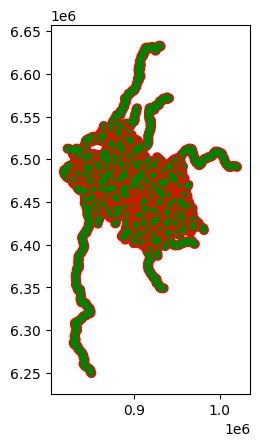

In [55]:
buffer_layer = cours_deau.buffer(5000)
buffer_layer.plot(color="green", edgecolor="red")

<Axes: >

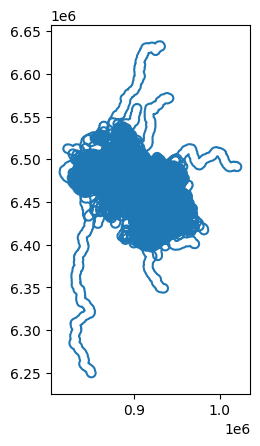

In [56]:
buffer_layer.boundary.plot()

<Axes: >

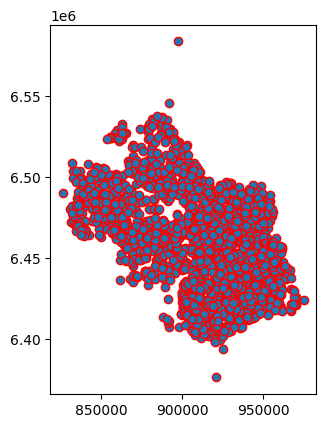

In [57]:
buffer_layer.centroid.plot(edgecolor='red')

In [58]:
cours_deau[['TOPONYME', 'IMPORTANCE']].head()

,TOPONYME,IMPORTANCE
0,Canal de Pulivès,5
1,Torrent du Clot des Cavales,5
2,le Bouveyron,5
3,Ruisseau de la Combe de Mouze,5
4,le Pachoux,5


In [14]:
cours_deau[cours_deau.TOPONYME == 'Canal du Furon']

,ID,CODE_HYDRO,TOPONYME,STATUT_TOP,IMPORTANCE,DATE_CREAT,DATE_MAJ,DATE_APP,DATE_CONF,SOURCE,ID_SOURCE,STATUT,MAREE,PERMANENT,COMMENT,geometry
1236,COURDEAU0000002000796489,06C0000002000796489,Canal du Furon,Validé,5,2017-01-24 16:06:18,2021-09-16 13:50:18,None,None,None,None,Validé,None,None,None,"LINESTRING (904717.400 6447571.200, 904712.000..."


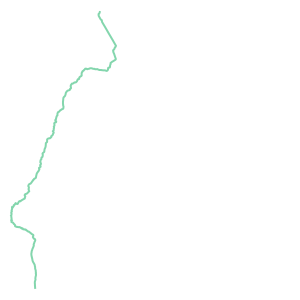

In [23]:
geom = cours_deau.loc[(cours_deau[cours_deau.TOPONYME == 'Canal du Furon'].index[0], 'geometry')]
geom

In [11]:
mnt = rio.open('../data/DEM_N245E395_l93.tif')
print(mnt.meta)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 3.4028234663852886e+38, 'width': 2393, 'height': 2000, 'count': 1, 'crs': CRS.from_epsg(2154), 'transform': Affine(22.625939867401588, 0.0, 876147.6561479433,
       0.0, -27.206653628468978, 6496734.7862259)}


In [12]:
from rasterio.plot import show

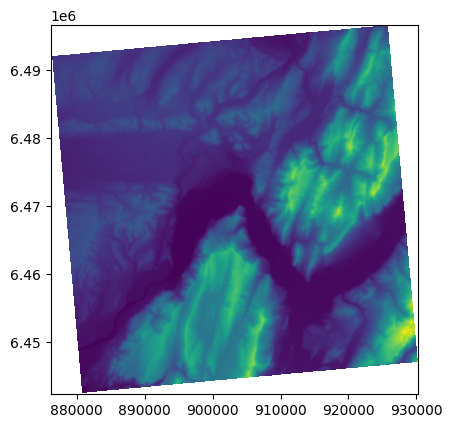

<Axes: >

In [13]:
show(mnt)

In [24]:
# geom est la géométrie récupérée plus tôt
length = geom.length

# combien de points :
nb_points = 50 

# quelle distance entre les points :
step = geom.length / nb_points

dists = []
coords = []
for dist in range(0, int(length), int(step)):
    pt = geom.interpolate(dist) # type(pt) -> shapely.geometry.Point
    # récupération des coordonnées du points sous forme d'un tuple :
    c = pt.coords[0]
    coords.append(c)
    dists.append(dist)

result = []
for i, value in enumerate(mnt.sample(coords)):
    result.append((dists[i], value[0]))

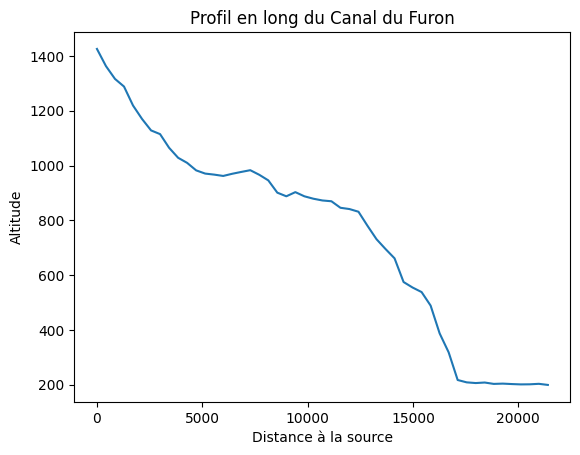

In [25]:
import matplotlib.pyplot as plt

plt.plot([i[0] for i in result], [i[1] for i in result])
plt.title('Profil en long du Canal du Furon')
plt.xlabel('Distance à la source')
plt.ylabel('Altitude')
plt.show()

In [32]:
result = []

for dist in range(0, int(length), int(step)):
    pt = geom.interpolate(dist)
    result.append({
        "geometry": pt,
        "distance_source": dist,
        "altitude": list(mnt.sample(pt.coords))[0][0],
    })

# Cette fois nous avons utilisé une liste
# contenant un dictionnaire pour chaque entité
# ... le résultat est le même qu'avec la méthode prédécente
sample_pts = gpd.GeoDataFrame(result, crs=cours_deau.crs)

# Toutes nos nouvelles entités vont prendre cette valeur
sample_pts['TOPONYME_COURS_DEAU'] = 'Canal du Furon'
sample_pts.head()

,geometry,distance_source,altitude,TOPONYME_COURS_DEAU
0,POINT (904717.400 6447571.200),0,1425.737671,Canal du Furon
1,POINT (904696.944 6447996.849),428,1362.941040,Canal du Furon
2,POINT (904755.972 6448415.457),856,1316.247681,Canal du Furon
3,POINT (904703.201 6448834.857),1284,1288.363037,Canal du Furon
4,POINT (904552.212 6449229.865),1712,1219.130859,Canal du Furon


In [33]:
sample_pts.to_file('/tmp/sample-pts.geojson')

In [35]:
%cat /tmp/sample-pts.geojson

{
"type": "FeatureCollection",
"crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:EPSG::2154" } },
"features": [
{ "type": "Feature", "properties": { "distance_source": 0, "altitude": 1425.7376708984375, "TOPONYME_COURS_DEAU": "Canal du Furon" }, "geometry": { "type": "Point", "coordinates": [ 904717.400000000023283, 6447571.200000000186265 ] } },
{ "type": "Feature", "properties": { "distance_source": 428, "altitude": 1362.9410400390625, "TOPONYME_COURS_DEAU": "Canal du Furon" }, "geometry": { "type": "Point", "coordinates": [ 904696.944100579014048, 6447996.848641823977232 ] } },
{ "type": "Feature", "properties": { "distance_source": 856, "altitude": 1316.2476806640625, "TOPONYME_COURS_DEAU": "Canal du Furon" }, "geometry": { "type": "Point", "coordinates": [ 904755.972066874848679, 6448415.456500354222953 ] } },
{ "type": "Feature", "properties": { "distance_source": 1284, "altitude": 1288.363037109375, "TOPONYME_COURS_DEAU": "Canal du Furon" }, "geometry": { "type":